In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

from pypower import BaseMatrix

plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = 'plots/'

In [9]:
factorin = 10
factorout = 5
xlim = (0.01, 0.6)

rp_cuts = [10, 20, 30]

wm = BaseMatrix.load('/global/cfs/cdirs/desi/users/mpinon/windows/wm_mock0_ELG_complete_SGC.npy')
wm_rpcut = BaseMatrix.load('/global/cfs/cdirs/desi/users/mpinon/windows/wm_mock0_ELG_complete_SGC_rp2.5.npy')
wm_rpcut_apd = [BaseMatrix.load('/global/cfs/cdirs/desi/users/mpinon/windows/wm_mock0_ELG_complete_SGC_rp2.5_apodized_tukey_rpzero{}.npy'.format(rp_cuts[i])) for i in range(len(rp_cuts))]

def unpack_wm(wmatrix):
    window_matrix = wmatrix.deepcopy()
    window_matrix.slice_x(slicein=slice(0, len(window_matrix.xin[0]) // factorin * factorin, factorin), sliceout=slice(0, len(window_matrix.xout[0]) // factorout * factorout, factorout))
    window_matrix.select_x(xoutlim=xlim)
    window_matrix.select_x(xinlim=(window_matrix.xout[0][0], window_matrix.xout[0][-1]))
    return window_matrix, window_matrix.unpacked()

wm, a = unpack_wm(wm)
wm_rpcut, a_rpcut = unpack_wm(wm_rpcut)
aux_rpcut_apd = [unpack_wm(wm_rpcut_apd[i]) for i in range(len(rp_cuts))]
wm_rpcut_apd = [aux_rpcut_apd[i][0] for i in range(len(rp_cuts))]
a_rpcut_apd = [aux_rpcut_apd[i][1] for i in range(len(rp_cuts))]

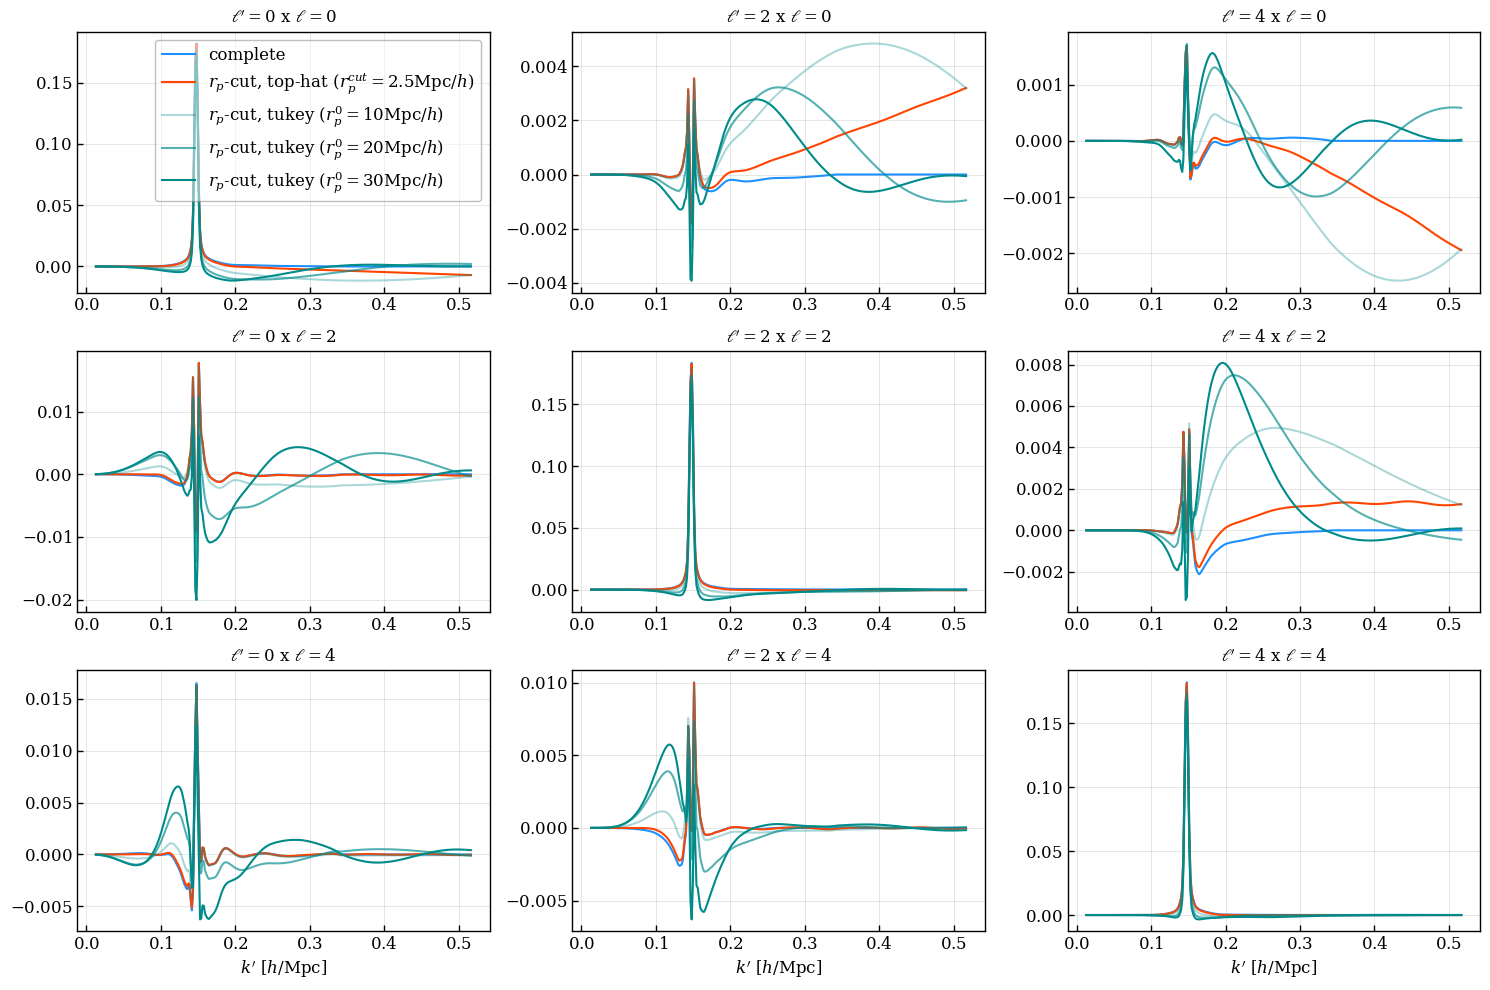

In [10]:
indexout = np.abs(wm.xout[0] - 0.15).argmin()

fig, lax = plt.subplots(len(wm.projsout), len(wm.projsin), figsize=(15, 10))
for iin, projin in enumerate(wm.projsin):
    for iout, projout in enumerate(wm.projsout):
        ax = lax[iout][iin]
        # Indices in approximative window matrix
        norm = 1.
        ax.plot(wm.xin[iin], a[iin][iout][:, indexout] / norm, label='complete')
        ax.plot(wm_rpcut.xin[iin], a_rpcut[iin][iout][:, indexout] / norm, label=r'$r_{{p}}$-cut, top-hat ($r_{p}^{cut} = 2.5 \mathrm{Mpc}/h$)', ls='-')
        for i in range(len(rp_cuts)):
            ax.plot(wm_rpcut_apd[i].xin[iin], a_rpcut_apd[i][iin][iout][:, indexout] / norm, label=r'$r_{{p}}$-cut, tukey ($r_{{p}}^{{0}} = {} \mathrm{{Mpc}}/h$)'.format(rp_cuts[i]), ls='-', color='darkcyan', alpha=(i+1)/len(rp_cuts))
        #lax[iout][iin].plot(wm_rpcut.xin[iin], a_rpcut[iin][iout][:, indexout] - a[iin][iout][:, indexout], label='$r_{p}$-cut')
        ax.set_title(r'$\ell^\prime = {:d}$ x $\ell = {:d}$'.format(projin.ell, projout.ell))
        ax.grid(True)
        if iout == len(wm.projsout) - 1: ax.set_xlabel(r'$k^\prime$ [$h/\mathrm{Mpc}$]')
        if iin == iout == 0: lax[iout][iin].legend()
plt.savefig(os.path.join(plots_dir, 'wmatrix_apodized_rpcut_complete_kin015.png'), dpi=300)

In [23]:
from pypower import utils

def plot_matrix(mat, x1=None, x2=None, xlabel1=None, xlabel2=None, barlabel=None, label1=None, label2=None,
                corrcoef=False, figsize=None, norm=None, labelsize=None):

    size1, size2 = [row[0].shape[0] for row in mat], [col.shape[1] for col in mat[0]]

    def _make_list(x, size):
        if not utils.is_sequence(x):
            x = [x] * size
        return list(x)

    if x2 is None: x2 = x1
    x1, x2 = [_make_list(x, len(size)) for x, size in zip([x1, x2], [size1, size2])]
    if xlabel2 is None: xlabel2 = xlabel1
    xlabel1, xlabel2 = [_make_list(x, len(size)) for x, size in zip([xlabel1, xlabel2], [size1, size2])]
    if label2 is None: label2 = label1
    label1, label2 = [_make_list(x, len(size)) for x, size in zip([label1, label2], [size1, size2])]

    if corrcoef:
        mat = utils.cov_to_corrcoef(np.bmat(mat).A)
        cumsize1, cumsize2 = [np.insert(np.cumsum(size), 0, 0) for size in [size1, size2]]
        mat = [[mat[start1:stop1, start2:stop2] for start2, stop2 in zip(cumsize2[:-1], cumsize2[1:])] for start1, stop1 in zip(cumsize1[:-1], cumsize1[1:])]

    norm = norm or Normalize(vmin=min(item.min() for row in mat for item in row), vmax=max(item.max() for row in mat for item in row))
    nrows, ncols = [len(x) for x in [size2, size1]]
    figsize = figsize or tuple(max(n * 3, 6) for n in [ncols, nrows])
    if np.ndim(figsize) == 0: figsize = (figsize,) * 2
    xextend = 0.8
    fig, lax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False,
                            figsize=(figsize[0] / xextend, figsize[1]),
                            gridspec_kw={'width_ratios': size1, 'height_ratios': size2[::-1]},
                            squeeze=False)
    wspace = hspace = 0.18
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    for i in range(ncols):
        for j in range(nrows):
            ax = lax[nrows - j - 1][i]
            xx1, xx2 = x1[i], x2[j]
            if x1[i] is None: xx1 = 1 + np.arange(mat[i][j].shape[0])
            if x2[j] is None: xx2 = 1 + np.arange(mat[i][j].shape[1])
            mesh = ax.pcolor(xx1, xx2, mat[i][j].T, norm=norm, cmap=plt.get_cmap('jet_r'))
            if i > 0 or x1[i] is None: ax.yaxis.set_visible(False)
            if j == 0 and xlabel1[i]: ax.set_xlabel(xlabel1[i], fontsize=labelsize)
            if j > 0 or x2[j] is None: ax.xaxis.set_visible(False)
            if i == 0 and xlabel2[j]: ax.set_ylabel(xlabel2[j], fontsize=labelsize)
            ax.tick_params()
            if label1[i] is not None or label2[j] is not None:
                text = '{}\nx {}'.format(label1[i], label2[j])
                ax.text(0.05, 0.95, text, horizontalalignment='left', verticalalignment='top',\
                        transform=ax.transAxes, color='black')

    fig.subplots_adjust(right=xextend)
    cbar_ax = fig.add_axes([xextend + 0.05, 0.15, 0.03, 0.7])
    cbar_ax.tick_params()
    cbar = fig.colorbar(mesh, cax=cbar_ax)
    if barlabel: cbar.set_label(barlabel, rotation=90)
    return lax

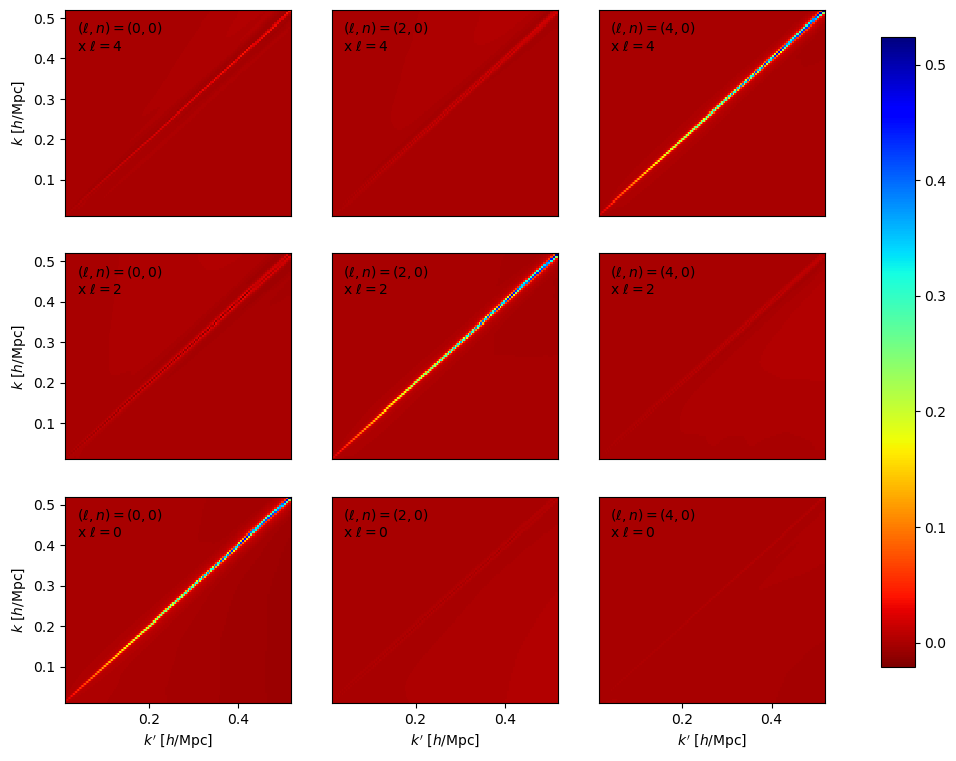

In [24]:
plot_matrix(a_rpcut, x1=wm_rpcut.xin, x2=wm_rpcut.xout, xlabel1=r'$k^\prime$ [$h/\mathrm{Mpc}$]', xlabel2=r'$k$ [$h/\mathrm{Mpc}$]',
            barlabel=None, label1=[proj.latex(inline=True) for proj in wm.projsin], label2=[proj.latex(inline=True) for proj in wm.projsout]);
plt.show()

array([[<AxesSubplot: ylabel='$k$ [$h/\\mathrm{Mpc}$]'>, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='$k$ [$h/\\mathrm{Mpc}$]'>, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: xlabel='$k^\\prime$ [$h/\\mathrm{Mpc}$]', ylabel='$k$ [$h/\\mathrm{Mpc}$]'>,
        <AxesSubplot: xlabel='$k^\\prime$ [$h/\\mathrm{Mpc}$]'>,
        <AxesSubplot: xlabel='$k^\\prime$ [$h/\\mathrm{Mpc}$]'>]],
      dtype=object)

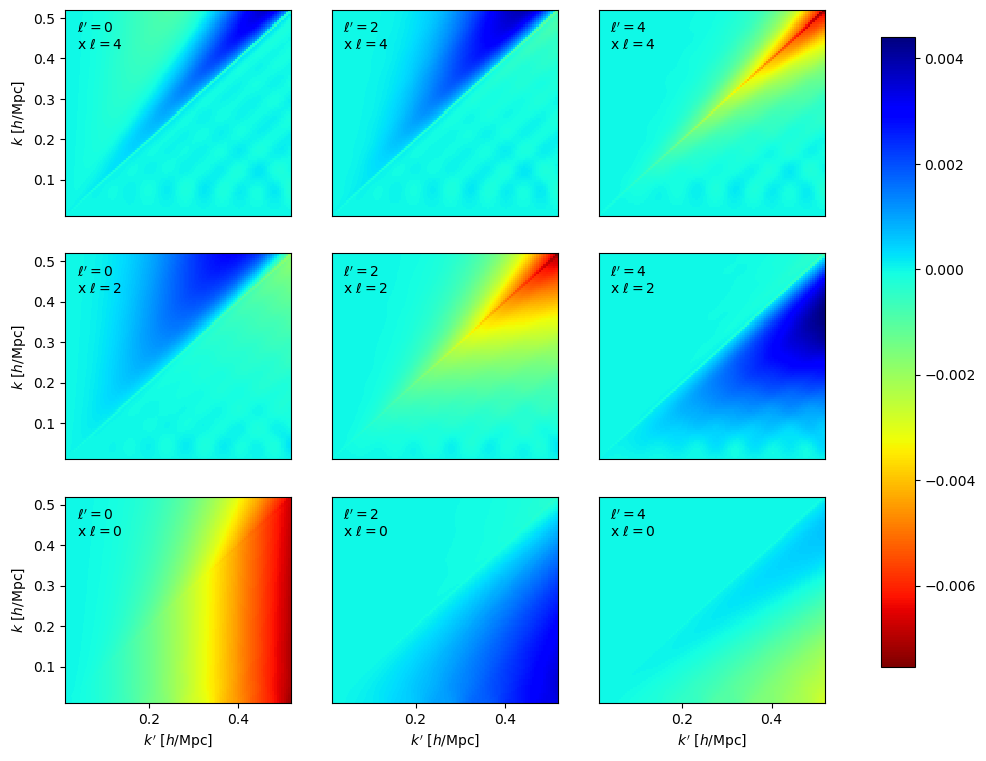

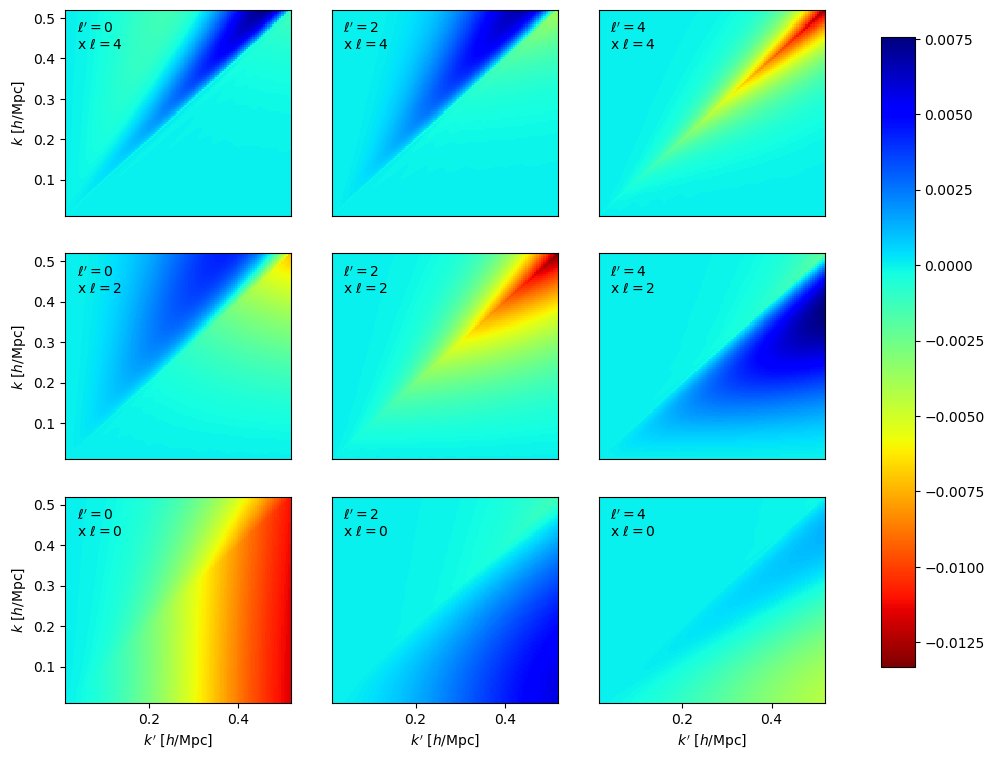

In [28]:
diff = [[ba_rpcut - ba for ba, ba_rpcut in zip(ca, ca_rpcut)] for ca, ca_rpcut in zip(a, a_rpcut)]

plot_matrix(diff, x1=wm.xin, x2=wm.xout, xlabel1=r'$k^\prime$ [$h/\mathrm{Mpc}$]', xlabel2=r'$k$ [$h/\mathrm{Mpc}$]',
            barlabel=None, label1=[r'$\ell^\prime = {:d}$'.format(proj.ell) for proj in wm.projsin], label2=[r'$\ell = {:d}$'.format(proj.ell) for proj in wm.projsout])

diff = [[ba_rpcut - ba for ba, ba_rpcut in zip(ca, ca_rpcut)] for ca, ca_rpcut in zip(a, a_rpcut2)]

plot_matrix(diff, x1=wm.xin, x2=wm.xout, xlabel1=r'$k^\prime$ [$h/\mathrm{Mpc}$]', xlabel2=r'$k$ [$h/\mathrm{Mpc}$]',
            barlabel=None, label1=[r'$\ell^\prime = {:d}$'.format(proj.ell) for proj in wm.projsin], label2=[r'$\ell = {:d}$'.format(proj.ell) for proj in wm.projsout])
